In [1]:
#basic
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use("fivethirtyeight")
%matplotlib inline
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from matplotlib import pyplot

# For reading stock data 
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

#modeling
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.model_selection import TimeSeriesSplit

np.random.seed(123)

### Univariate time series 
* ARIMA: combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I). AR(p), I(d), and MA(q) models as parameters
* ARIMA(data, order=(1, 1, 1))

* SARIMA: combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level. SARIMA(p, d, q)(P, D, Q)m where  AR(P), I(D), MA(Q) and m parameters at the seasonal level, “m” is the number of time steps in each season (the seasonal period)
* SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))

* SARIMAX: Exogenous variables are also called covariates and can be thought of as parallel input sequences that have observations at the same time steps as the original series.  
* SARIMAX(data1, exog=data2, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))

In [2]:
df = DataReader('AAL', data_source='yahoo', start='2012-01-01', end=datetime.now())

In [3]:
data = df.filter(['Close'])

In [4]:
dataset = data.values

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [6]:
training_data_len = int(np.ceil( len(dataset) * .9 ))
train_data = scaled_data[0:int(training_data_len), :]

In [7]:
train_data.shape

(2195, 1)

## ARISM

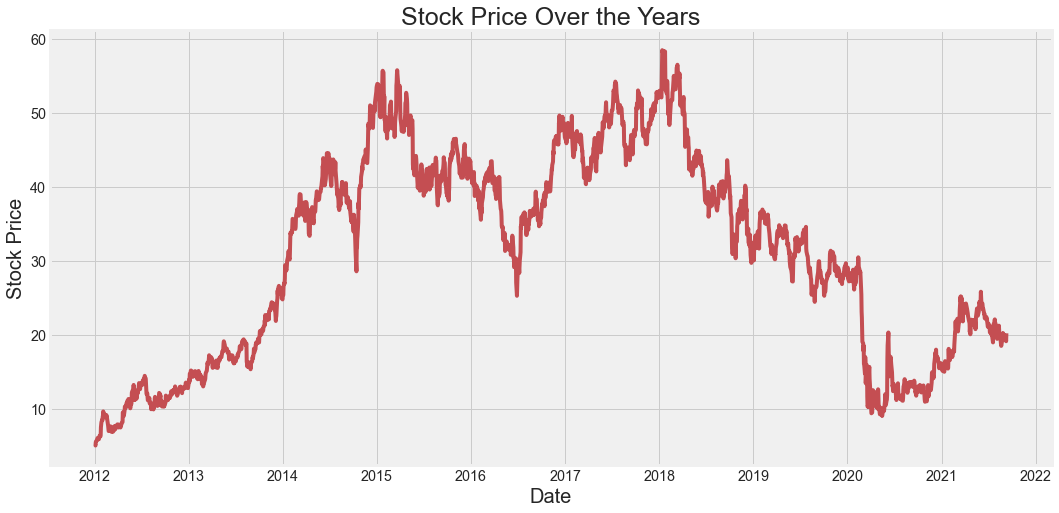

In [8]:
plt.figure(figsize=(16,8))
plt.plot(data['Close'], label='Close.',color='r')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Over the Years',size=25);

In [9]:
def adfuller_test(stocks):
    result=adfuller(stocks)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

In [10]:
adfuller_test(data)

ADF Test Statistic : -2.043166146715914
p-value : 0.2679726587689768
#Lags Used : 1
Number of Observations : 2436


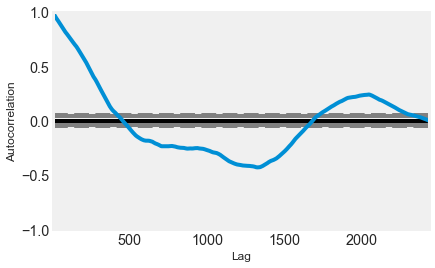

In [11]:
autocorrelation_plot(data['Close'])
plt.show()

In [12]:
data['Close First diff'] = data['Close'] - data['Close'].shift(1)
data['Close Seasonal diff']=data['Close']- data['Close'].shift(12)
data.head()

,Close,Close First diff,Close Seasonal diff
Date,,,
2012-01-03,5.12,NaN,NaN
2012-01-04,5.03,-0.09,NaN
2012-01-05,5.47,0.44,NaN
2012-01-06,5.60,0.13,NaN
2012-01-09,5.72,0.12,NaN


In [13]:
adfuller_test(data['Close Seasonal diff'].dropna())

#rejecting the null hypothesis. So data is stationary.

ADF Test Statistic : -7.827161223759474
p-value : 6.435764389641133e-12
#Lags Used : 24
Number of Observations : 2401


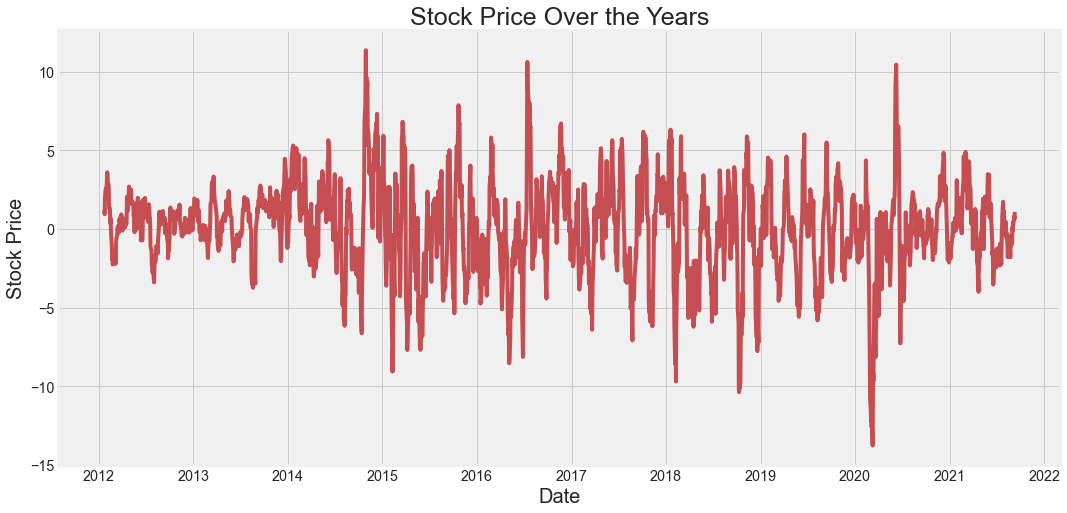

In [14]:
plt.figure(figsize=(16,8))
plt.plot(data['Close Seasonal diff'], label='Close Seasonal Diff.',color='r')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Over the Years',size=25);

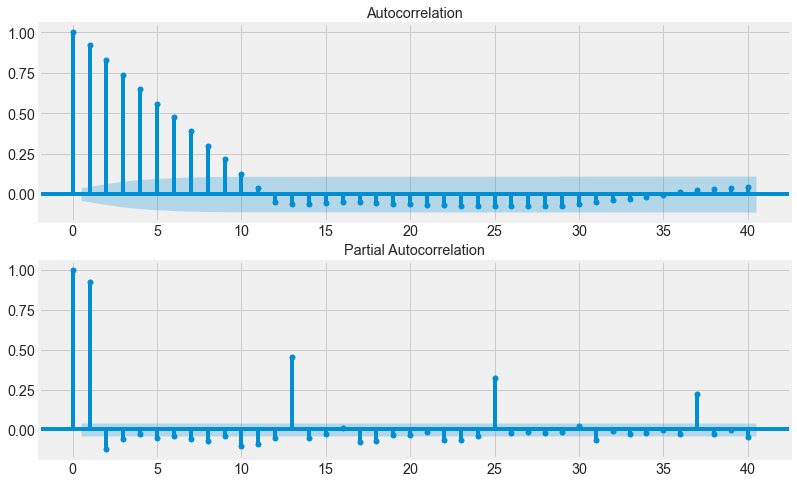

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['Close Seasonal diff'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['Close Seasonal diff'].dropna(),lags=40,ax=ax2)

No handles with labels found to put in legend.


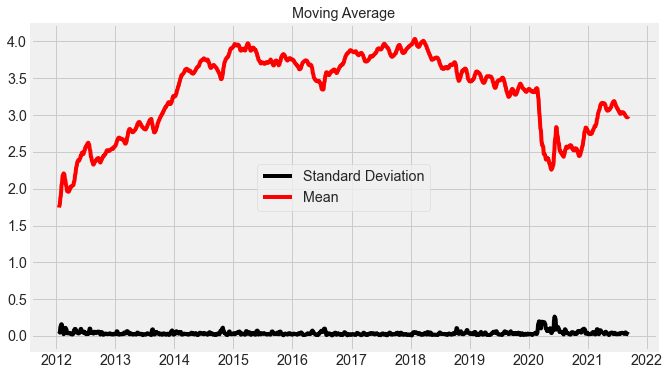

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(data['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

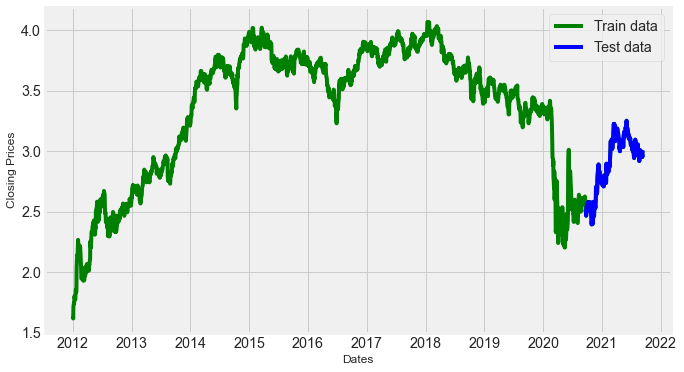

In [17]:
train_data, test_data = df_log[0:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [18]:
len(test_data)

244

### Model1 Base model

In [19]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train_data):
    print(train_ind, val_ind)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

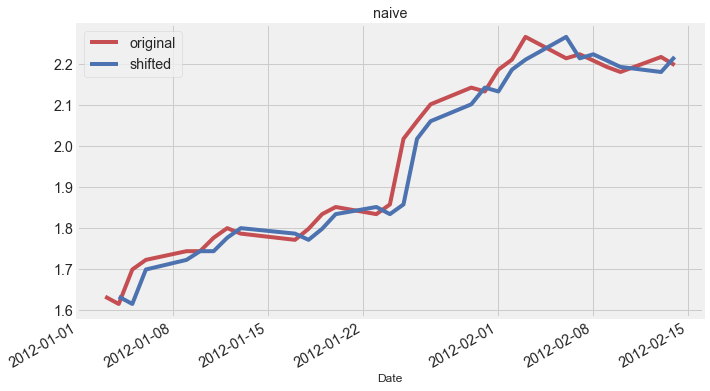

In [20]:

naive = train_data.shift(1)
fig, ax = plt.subplots()

train_data[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [21]:
np.sqrt(mean_squared_error(train_data[1:], naive.dropna()))

0.03145847102891326

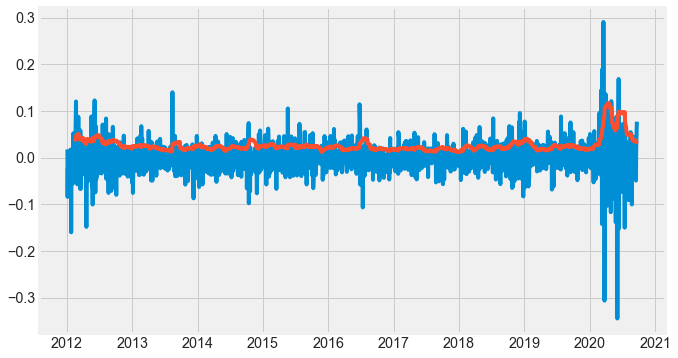

In [22]:
fig, ax = plt.subplots()
residuals = naive[1:] - train_data[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

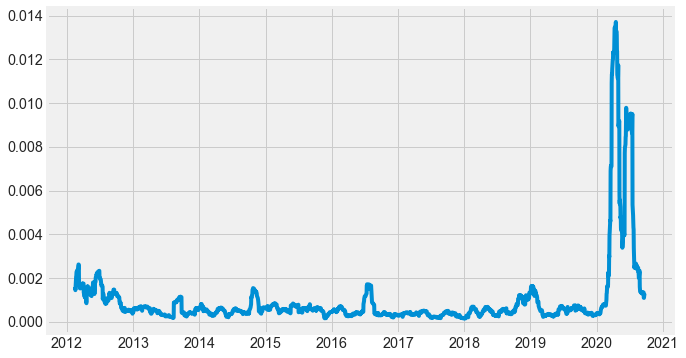

In [23]:
fig, ax = plt.subplots()
ax.plot(residuals.index, residuals.rolling(30).var());

### Model2 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8944.439, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8965.755, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8966.268, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8946.091, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8964.274, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8964.279, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8962.305, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8967.987, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8965.992, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-8965.909, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8967.479, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8964.021, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.105 seconds
                               SARIMAX Results                              

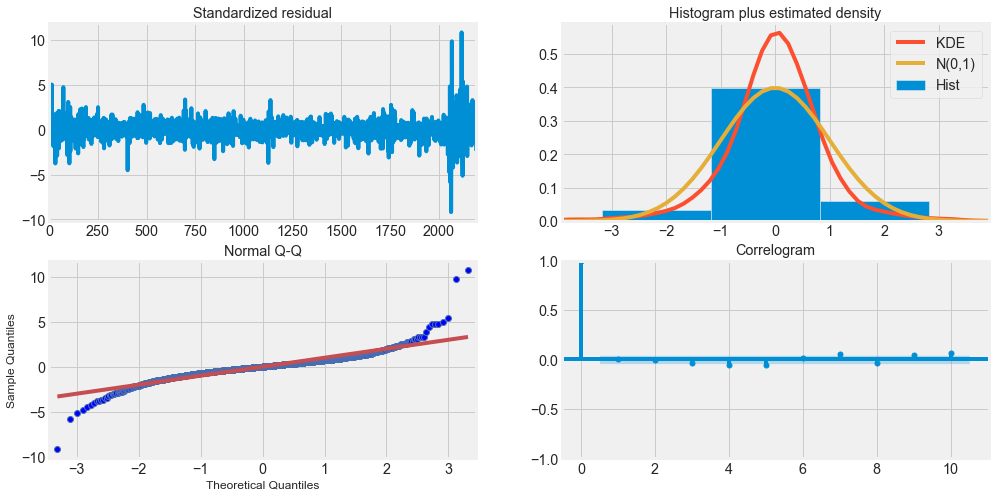

In [35]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=9, max_q=9, # maximum p and q
                      m=1,              # frequency of series
                      d=1,          # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

1. The top left plot shows the residuals over time. We do not want to see any obvious seasonality here and the messier it is, the better we can say we found the trend and seasonality in our data and removed the noise.

2. In the top-right plot, we want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.

3. In the bottom left qq-plot, you see the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).

4. The autocorrelation visual (called a “correlogram”) on the bottom right shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

In [25]:
#The best ARIMA model with p,d,q values is 0,1,1 and Seasonal P,D,Q with 0,0,0

model = ARIMA(train_data, order=(0,1,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2193
Model:                 ARIMA(0, 1, 1)   Log Likelihood                4486.134
Method:                       css-mle   S.D. of innovations              0.031
Date:                Thu, 09 Sep 2021   AIC                          -8966.268
Time:                        17:50:09   BIC                          -8949.189
Sample:                             1   HQIC                         -8960.027
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.001      0.530      0.596      -0.001       0.002
ma.L1.D.Close     0.1049      0.021      4.936      0.000       0.063       0.147
                                    Root

<AxesSubplot:xlabel='Date'>

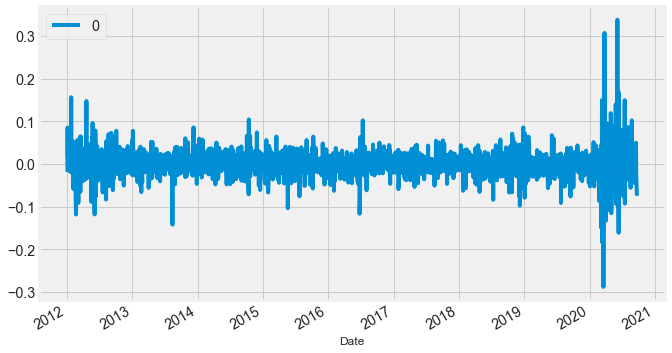

In [26]:
residuals = pd.DataFrame(fitted.resid)
residuals.plot()

In [27]:
print(residuals.describe())

                 0
count  2193.000000
mean      0.000001
std       0.031293
min      -0.287693
25%      -0.013928
50%       0.000397
75%       0.015261
max       0.338233


In [28]:
#fc=Array of out of sample forecasts
#se=Array of the standard error of the forecasts.
#conf=2d array of the confidence interval for the forecast

fc, se, conf = fitted.forecast(244, alpha=0.05)  #95% conf

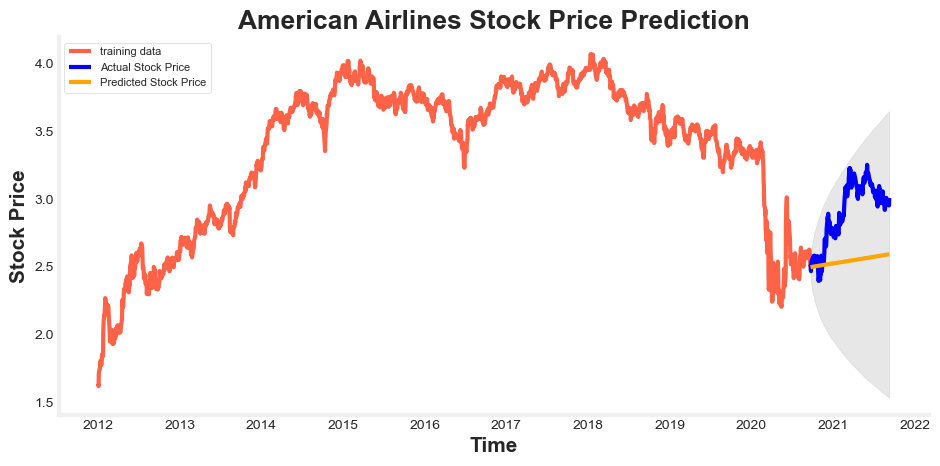

In [29]:
# Make as pandas series

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
with plt.style.context('images/presentation.mplstyle'):
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training data')
    plt.plot(test_data, color = 'blue', label='Actual Stock Price')
    plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.10)
    plt.title('American Airlines Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend(loc='upper left', fontsize=8)
#plt.savefig('images/ARIMA.png')
  


In [30]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.17531659805196892
MAE: 0.36934136743589285
RMSE: 0.41870824932399997
MAPE: 0.12238233747550348


predicted=12.146651, expected=12.340000
predicted=12.352078, expected=11.930000
predicted=11.929090, expected=11.770000
predicted=11.762564, expected=12.290000
predicted=12.344455, expected=12.760000
predicted=12.801545, expected=12.250000
predicted=12.212959, expected=12.290000
predicted=12.283478, expected=12.580000
predicted=12.608828, expected=13.000000
predicted=13.029834, expected=13.120000
predicted=13.131604, expected=12.530000
predicted=12.483223, expected=13.070000
predicted=13.101887, expected=13.160000
predicted=13.181179, expected=13.200000
predicted=13.195186, expected=12.920000
predicted=12.906275, expected=12.220000
predicted=12.168498, expected=12.360000
predicted=12.374824, expected=12.230000
predicted=12.240254, expected=12.460000
predicted=12.478941, expected=12.560000
predicted=12.579121, expected=12.800000
predicted=12.814371, expected=12.750000
predicted=12.749350, expected=13.150000
predicted=13.173333, expected=12.600000
predicted=12.567359, expected=11.800000


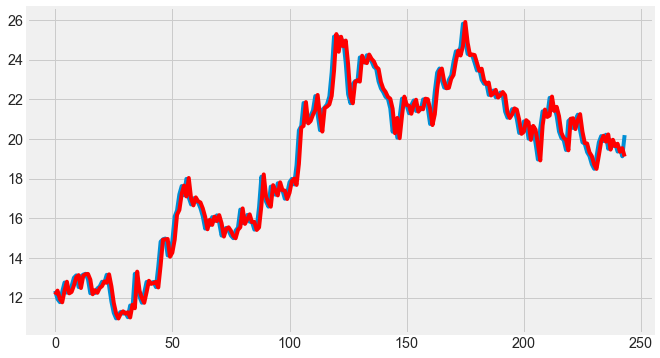

In [31]:
size = int(len(dataset) * 0.9)
train, test = dataset[0:size], dataset[size:len(dataset)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()